In [1]:
from __future__ import print_function
import os, sys, glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pickle

from config import CURRENT_DIR
CHESSBOARD_IMAGES_PATH = os.path.join(CURRENT_DIR, "../camera_cal")
IMAGE_PATH = os.path.join(CURRENT_DIR, "../test_images")

# Utility function 

In [55]:
def plt_imshow_multiple(imgs, image_names, callback_func = plt.imshow, cmap=None):
    figure = plt.figure(figsize=(20, 20))
    num_rows = 3
    num_cols = int(len(imgs) / num_rows)

    ax = []
    for i in range(num_cols * num_rows):
        ax.append(figure.add_subplot(num_rows, num_cols, i+1))
        ax[-1].set_title(image_names[i])
        if (callback_func == plt.imshow):
            callback_func(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB), cmap)
        else:
            callback_func(imgs[i])


    plt.show()

# Camera Calibration

In [3]:
chessboard_images_names = glob.glob(CHESSBOARD_IMAGES_PATH + "/calibration*.jpg")

NUMBER_CORNER_XAXIS = 9
NUMBER_CORNER_YAXIS = 6

objp = np.zeros((NUMBER_CORNER_XAXIS*NUMBER_CORNER_YAXIS, 3), np.float32)
objp[:,:2] = np.mgrid[0:NUMBER_CORNER_YAXIS, 0:NUMBER_CORNER_XAXIS].T.reshape(-1,2)

objpoints = []
imgpoints = []

img_size = None
for idx, fname in enumerate(chessboard_images_names):
    img = cv2.imread(fname)
    if (not img_size):
        img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (NUMBER_CORNER_YAXIS,NUMBER_CORNER_XAXIS), None)

    del img
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

In [4]:
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open(os.path.join(CURRENT_DIR, "../models/calibration.p"), "wb"))

# Process Test Image

In [5]:
if mtx not in dir() or dist not in dir():
    dist_pickle = pickle.load(open(os.path.join(CURRENT_DIR, "../models/calibration.p"), "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]


import os
image_names = os.listdir(IMAGE_PATH)
imgs = [cv2.imread(os.path.join(IMAGE_PATH, image_name)) for image_name in image_names]
undistorted_imgs = [cv2.undistort(img, mtx, dist, None, mtx) for img in imgs]

/home/buggy/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


# Original test images

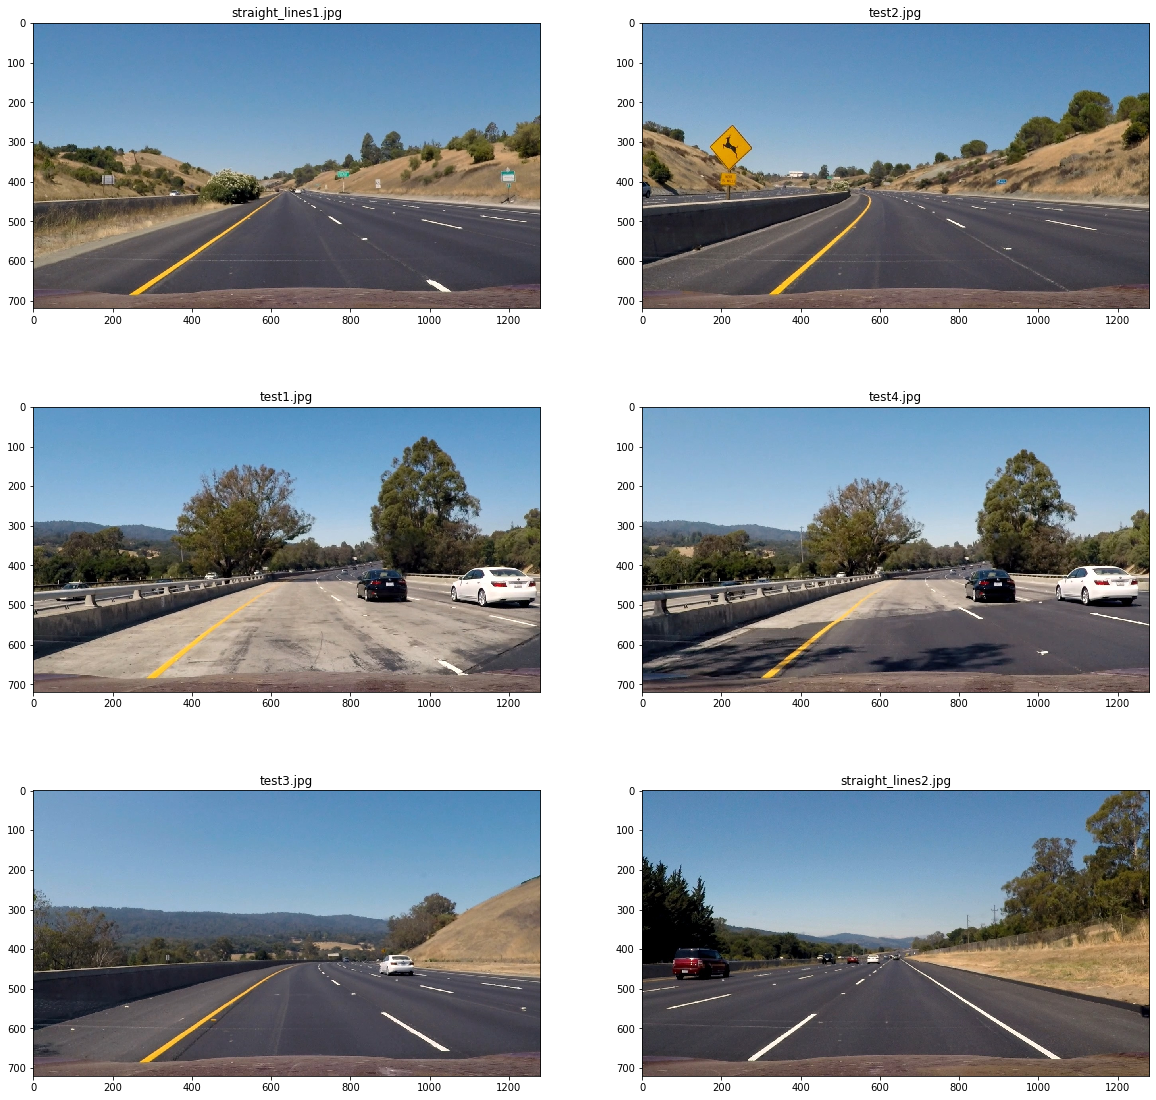

In [6]:
plt_imshow_multiple(imgs, image_names)

# Undistorted images

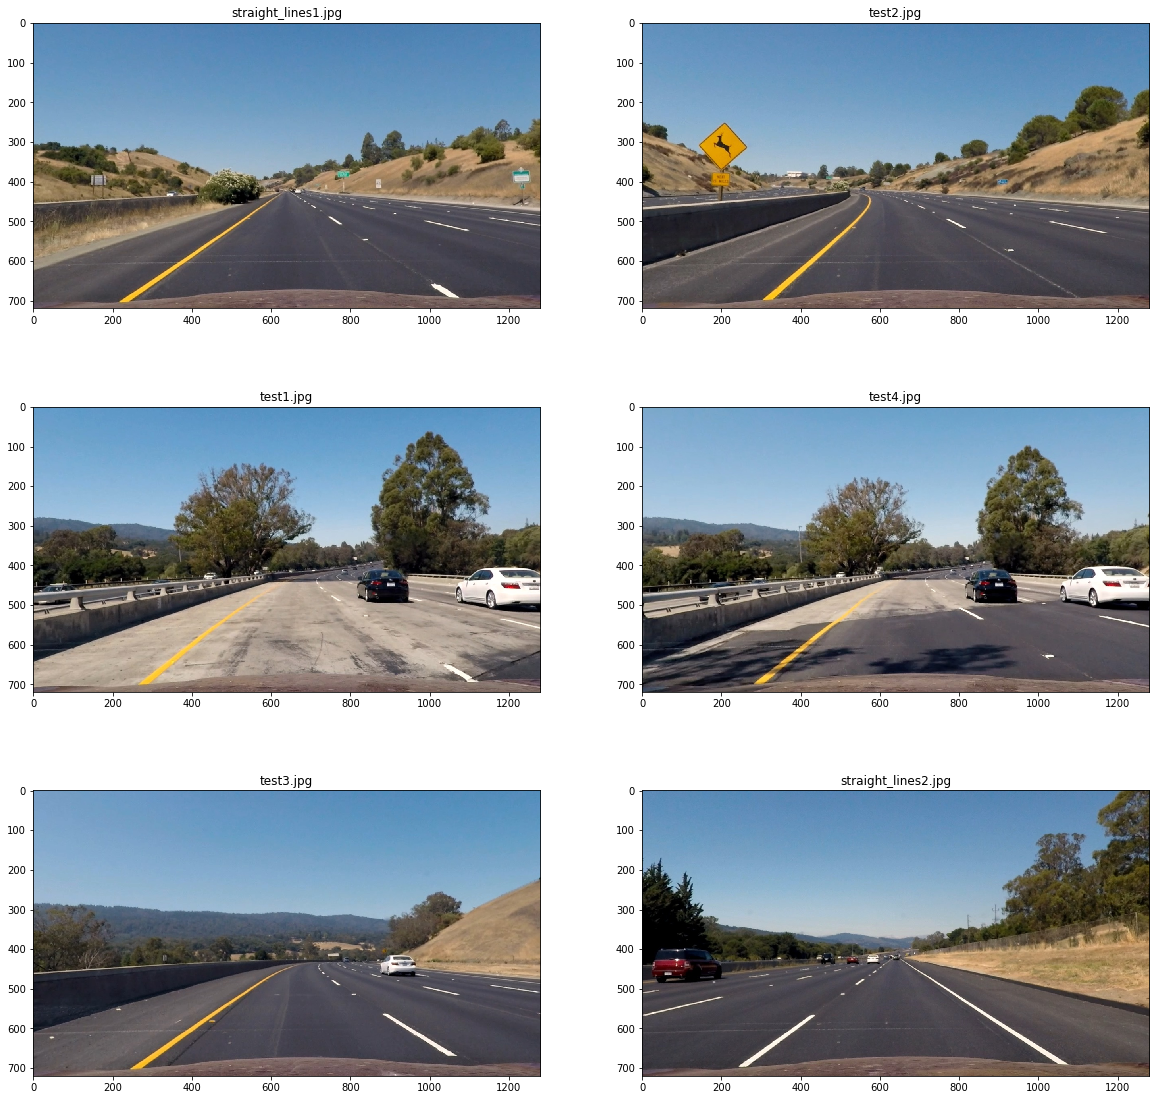

In [7]:
plt_imshow_multiple(undistorted_imgs, image_names)

# Perspective transform

In [8]:
def perspective_transform(img, offset=0):
    assert(img.ndim == 3)
    HEIGHT, WIDTH = img.shape[:2]

    src = np.float32([
        [WIDTH / 2 - 60, HEIGHT / 1.62],
        [WIDTH / 2 + 80, HEIGHT / 1.62],
        [WIDTH / 15, HEIGHT - 5],
        [WIDTH - 1 - WIDTH / 15, HEIGHT - 5],
    ])
    dst = np.float32([
        [offset, offset],
        [WIDTH-offset, offset],
        [offset, HEIGHT-offset],
        [WIDTH-offset, HEIGHT-offset],
    ])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, (WIDTH, HEIGHT), flags=cv2.INTER_LINEAR)


transformed_images = [perspective_transform(img) for img in undistorted_imgs]

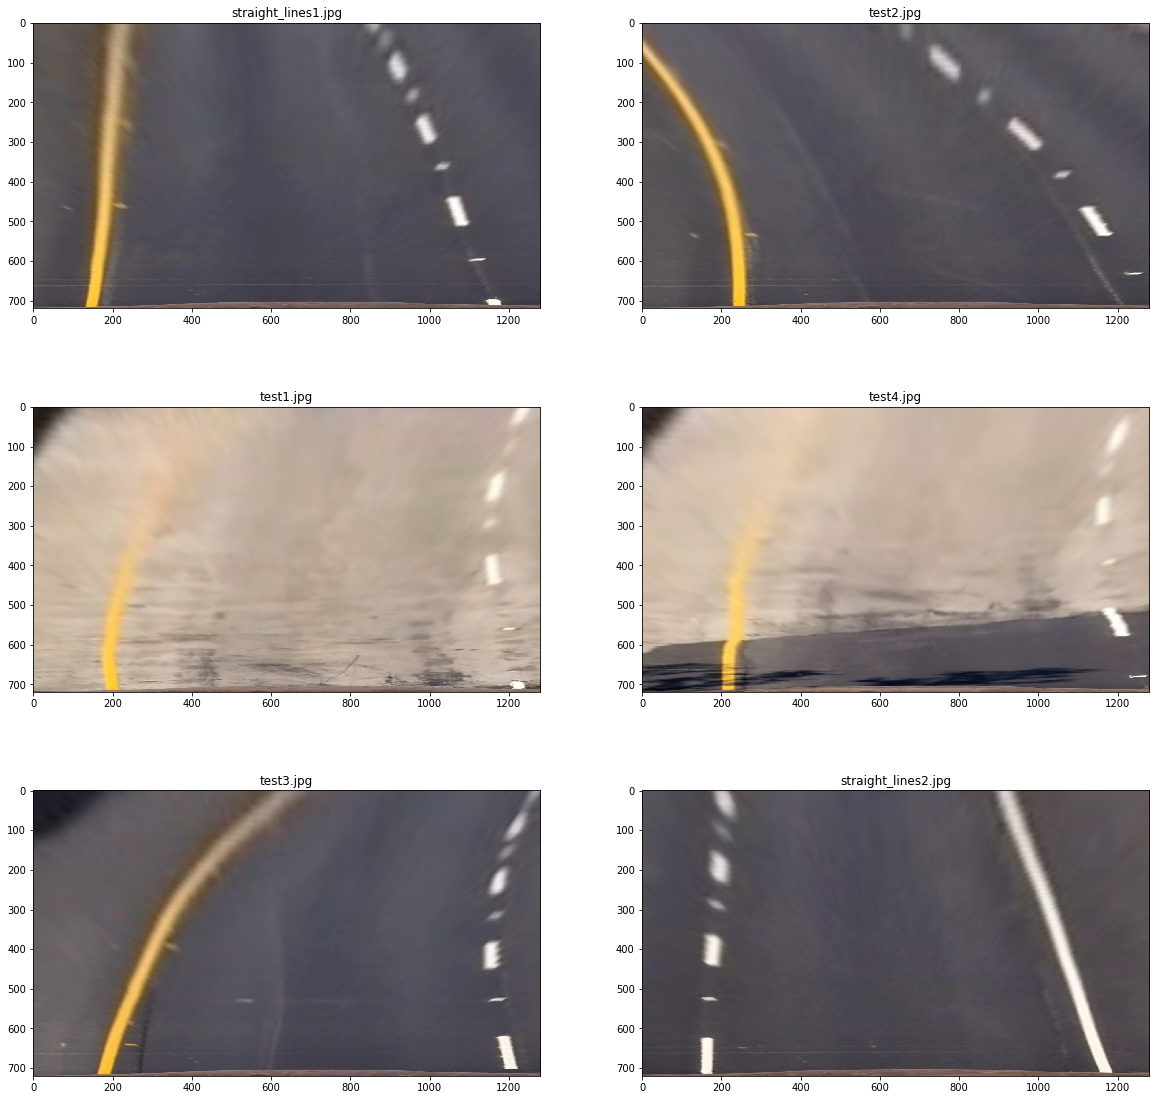

In [9]:
plt_imshow_multiple(transformed_images, image_names)

# Preprocessing the undistored image

In [10]:
sys.path.append(os.path.join(CURRENT_DIR, ".."))
from image_processing import *

In [48]:
def thresholding_on_color(img):
    hsv_img = hsv(img)
    thresholding_on_yellow = cv2.inRange(hsv_img, (15,100,100), (30,255,255))
    thresholding_on_white = cv2.inRange(img, (200,200,200), (255,255,255))

    combined_result = np.zeros_like(hsv_img[:,:,0])
    combined_result[(thresholding_on_yellow > 0) | (thresholding_on_white > 0)] = 1
    return combined_result
    
def preprocess_single_image(img):
    assert(img.ndim == 3)
    hls_image = hls(img)
    s_channel = hls_image[:,:,2]
    thresholded_on_color = thresholding_on_color(img)

    thresholded_sobel_x = abs_sobel_thresh(s_channel, orient='x', thresh_min=15, thresh_max=100)
    
    thresholded_binary_image = np.zeros_like(s_channel)
    thresholded_binary_image[(thresholded_sobel_x == 1) | (thresholded_on_color == 1)] = 1
    
    return thresholded_binary_image

In [49]:
thresholded_imgs = [preprocess_single_image(img) for img in transformed_images]
thresholded_imgs = list(map(lambda img : img * 255, thresholded_imgs))

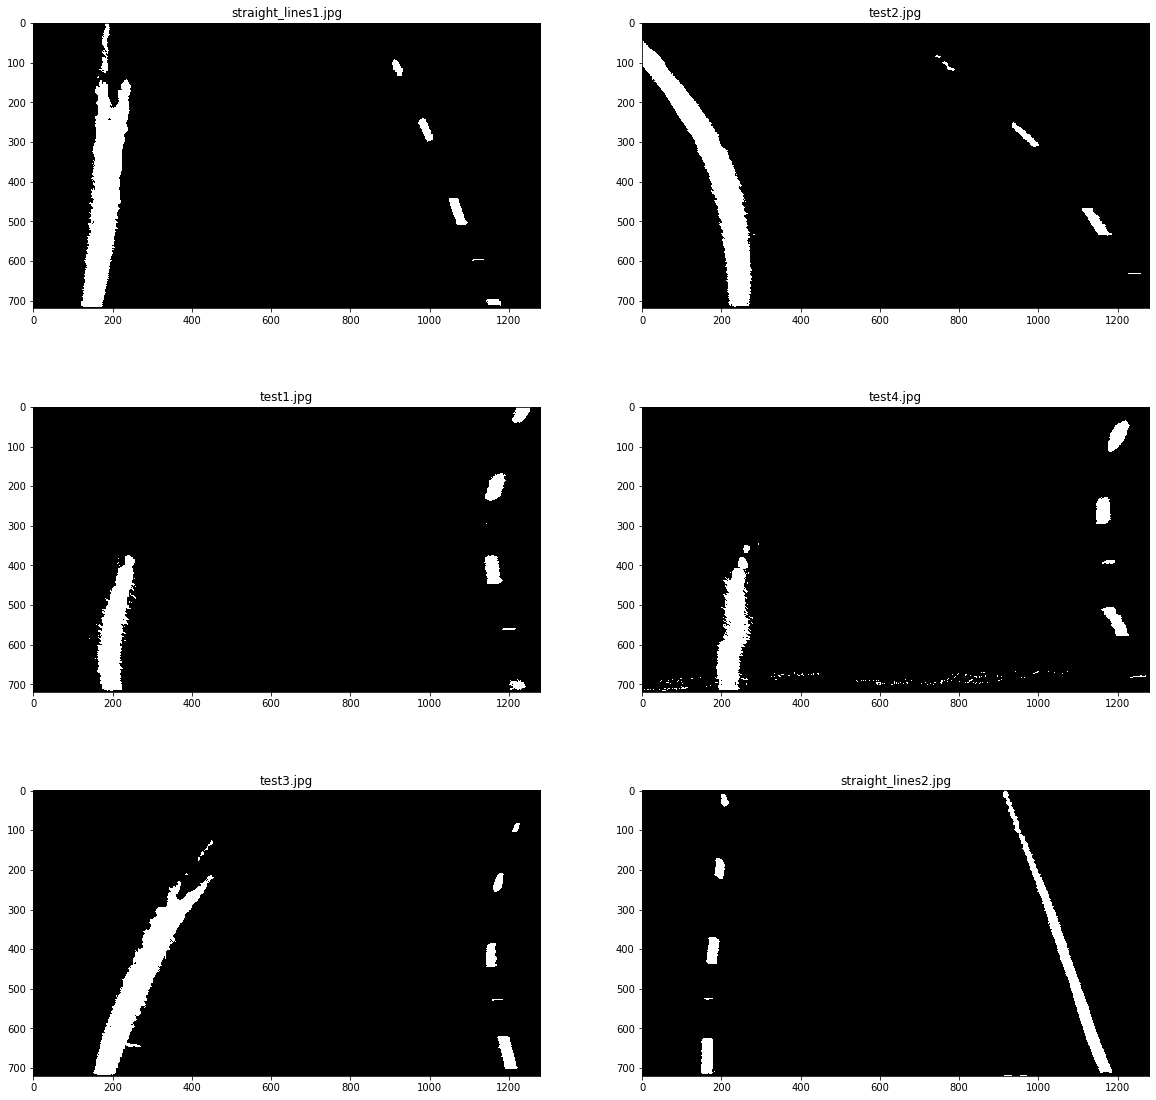

In [53]:
plt_imshow_multiple(thresholded_imgs, image_names, cmap="gray")

# Sliding windows

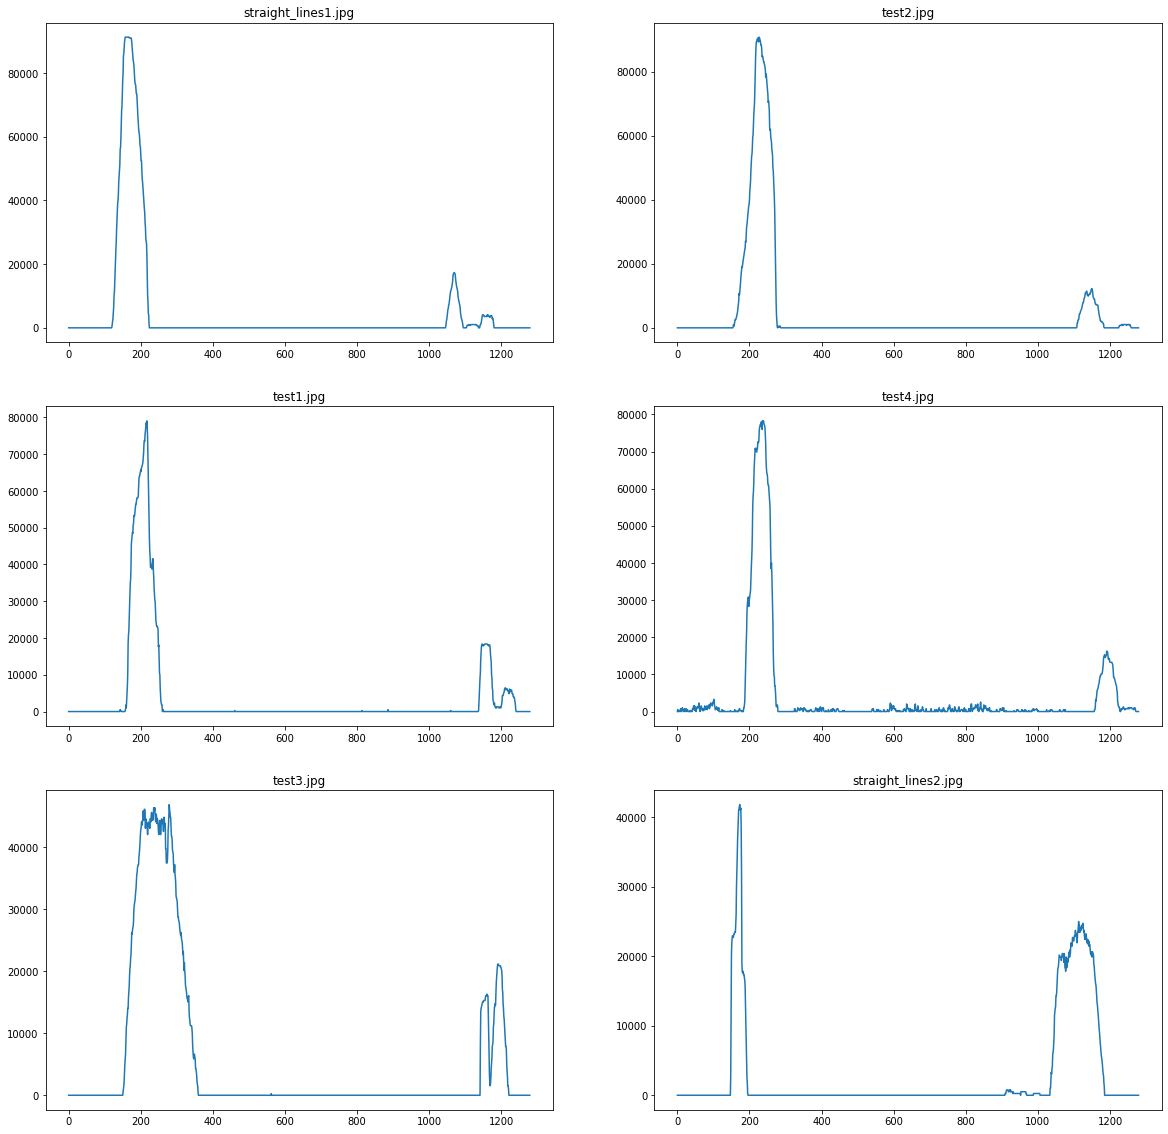

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def estimate_histogram(img):
    assert(img.ndim == 2)
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    return histogram

histograms = [estimate_histogram(img) for img in thresholded_imgs]
plt_imshow_multiple(histograms, image_names, callback_func=plt.plot)